# Microscopic Image Analysis

## Learning Objectives

Using micrographs and real biological data, you will learn the following across the course of this extended lesson:

- Basic image handling: reading in image files, and how to convert them into numerical arrays.
- Measurement of pixel intensity, ploting these data as histograms, and learning how to equalise these intensity values across an image.
- OpenCV to normalise pixel intensity values of one channel relative to another, to normalise an image.
- Constructing scatter plots to observe correlations between the pixel intensities of each channel.
- Clustering multiple data points, helping to clearly identify distinct distributions.
- Selecting and zoning in on specific parts of an image, for analyses.
- Implementation of image clustering.
- Counting nuclei *via* image segmentation, targeting cell nuclei using StarDist.

## Why is Image Analysis important?

Image Analysis extracts meaningful data, and can be useful in many different applications. Such as:

1. Analysing fluorescent digital slides, which can help quantitate the area of staining of a particular biomarker.
2. Image analysis tools can help to automate repetitive processes, and provide quantitative data that is accurate and repeatable, telling you about each slide: beyond the capabilities of manual microscopy.
3. Image analyses performed on fluorscent micrographs can help answer questions such as:
    • How much area of a tissue sample is stained for a particular biomarker?
    • What is the average intensity of a biomarker staining throughout the sample?
    • Do multiple biomarkers co-localize in the tissue, or within individual cells? If so, to what extent?

### What is an image?

Images are essentially a matrix in which each index is assigned a number, representing the value at that specifc point. 

These indices, more commonly called pixels, are a measure of how many photons hit that particular position on the camera sensor. As these images are matrices, we can do many of the same mathematical operations on images as we do on matrices. However, we don't want to manually generate every image by populating a matrix. This means that we will have to have some manner of interacting with image files on our computer, programmatically. 

For all scientific images, you should save them in a file format that minimizes the data lost due to compression. In the field of image analysis, the most common file format you will run into is the Tagged Image File Format (.tiff or .tif) which is a lossless compression format. 

In this tutorial, we will learn how to load, manipulate and extract quantitative data from microscopy images. The data set used in this experiment has been taken from [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/BBBC008) and presents *Human HT29 colon-cancer cells*.

#### Images in dataset

The image set consists of 12 individual images. The samples were stained with Hoechst (channel 1), pH3 (channel 2), and phalloidin (channel 3). Hoechst labels DNA, which is present in the nucleus. Phalloidin labels actin, which is present in the cytoplasm. The last stain - pH3 - is used to indicate cells in mitosis, and is irrelevant for segmentation and counting, so this channel will be ommitted. In this tutorial we will be exploring channel 1 for nuclei, and channel 3 for the cytoplasm.

### Packages

There are several image processing libraries available in Python, such as *Python Imaging Library*, *Sci-kit Image*, *Scipy.ndimage* and *Open CV*. While each have their own features, they all have the same (or at least very similar) utilities. In this lesson, we will be using the *Python Imaging Library* and *Sci-kit Image*, as these have everything we require, packaged together in easy-to-use functions.

The *Python Imaging Library (PIL)* has a large number of modules and submodules. Each submodule has an array of functions assoicated with a certain type of operation. For example, we will be using module **Image** which provides a number of factory functions, including functions to load images from files, and to create new images.

For other basic processing and plotting in Python, the scientific packages Numpy and Matplotlib are needed.

In [3]:
# Loading the packages

from PIL import Image # Python Image Library (Pillow)
from skimage import exposure

import matplotlib.pyplot as plt
import numpy as np

import glob


## Loading images
To begin, let's read in all the images from a directory, and then load an image into memory using the **open** function from the **Image** module of *Python Imaging Library*. This function opens and identifies the given image file.

In [5]:
## Get image files

ch1_files = glob.glob('human_ht29_colon_cancer_2_images/*_channel1.tif') # channel 1 image - nuclei
ch3_files = glob.glob('human_ht29_colon_cancer_2_images/*_channel3.tif') # channel 3 image - cytoplasm

## Check they are correctly paired
print(ch1_files[0], ":", ch3_files[0], "\n")

## Sort files

ch1_files.sort()
ch3_files.sort()

## Check they are correctly paired
print("Correctly paired .... \n")
print(ch1_files[0], ":", ch3_files[0], "\n") # First file
print(ch1_files[11], ":", ch3_files[11], "\n") # Last file

## Load the first image

im1 = Image.open(ch1_files[0])
im3 = Image.open(ch3_files[0])


human_ht29_colon_cancer_2_images/AS_09125_050116000001_L15f00d0_slice3_channel1.tif : human_ht29_colon_cancer_2_images/AS_09125_050116000001_L15f00d0_slice4_channel3.tif 

Correctly paired .... 

human_ht29_colon_cancer_2_images/AS_09125_050116000001_A24f00d0_slice1_channel1.tif : human_ht29_colon_cancer_2_images/AS_09125_050116000001_A24f00d0_slice1_channel3.tif 

human_ht29_colon_cancer_2_images/AS_09125_050116000001_L15f00d0_slice6_channel1.tif : human_ht29_colon_cancer_2_images/AS_09125_050116000001_L15f00d0_slice6_channel3.tif 



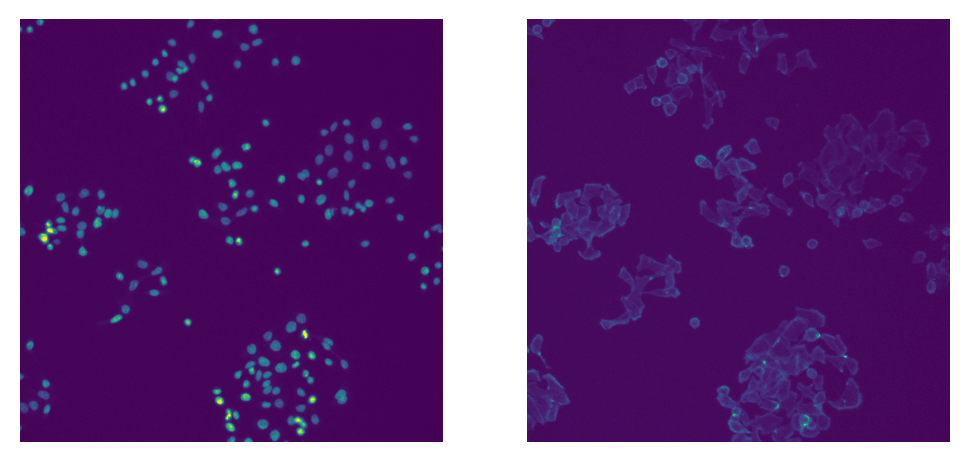

In [6]:
## Show Data

fig, axs = plt.subplots(1,2, dpi = 200)

axs[0].imshow(im1);
axs[0].axis('off')

axs[1].imshow(im3);
axs[1].axis('off');


In [7]:
type(im1)

PIL.TiffImagePlugin.TiffImageFile

The above command shows the type of image object **im1**. In order to perform any analyses, we need to have the numerical information of an image, which exists as arrays. The arrays are implemented by a package called Numpy, which is foundational to the entire scientific Python ecosystem. As soon as we perform numerical computations, we use data in the form of Numpy arrays. 

Below, we convert the image object into an array, as follows:


In [8]:
## Convert image into array

data1 = np.asarray(im1)
data3 = np.asarray(im3)

print('Image has', data1.shape[0], 'by', data1.shape[1], 'pixels') # check the shape of array
print('')
print('Total number of pixels is', data1.size) # check the size of array

Image has 512 by 512 pixels

Total number of pixels is 262144


In [65]:
# Check the content of the array

print(data1)
print('')
print(data1[10:20, 10:20])
print('')
print('Array type:', type(data1))
print('Data type: ',  data1.dtype)

[[11 11 11 ...  9 10 10]
 [12 11 11 ... 10  9 11]
 [11 11 11 ... 10 11 10]
 ...
 [11 11 11 ... 10 10 10]
 [12 11 11 ...  9 10 10]
 [11 11 11 ... 10 10 10]]

[[128 150 137 100  53  27  18  14  12  10]
 [155 177 172 136  73  38  21  15  11  11]
 [140 146 154 144  96  50  24  15  13  11]
 [133 144 139 122  95  55  26  15  13  11]
 [114 117 122 103  78  46  22  14  11  10]
 [ 79  87  97  78  54  32  18  12  11  12]
 [ 48  54  53  46  27  20  14  12  10  11]
 [ 20  22  23  20  15  13  13  11  11  11]
 [ 17  16  15  14  13  11  11  11  10  12]
 [ 12  14  14  13  14  12  12  12  11  11]]

Array type: <class 'numpy.ndarray'>
Data type:  uint8


The type function has returned numpy.ndarray where nd stands for n-dimensional, as Numpy can handle data of any dimension. The above output only shows us a fraction of the image, with the ```...``` indicating non-displayed values. We can also observe `dtype`, which tells us the type of the pixels within the array. The variable data1 is an array, but its content can vary: we could have floating point values, integers *etc*. Here, uint8 tells us we have unsigned (no negative values) integers in 8 bit, *i.e.* up to $2^8$ different possible pixel values.

In microscopy, the flourecent images are labelled with three colours: red, green and blue (RGB). An RGB image is simply a stack of three two-dimensional arrays. The image in the first dimension will have a red colour map, the second a green colour map, and the third a blue colour map. In this dataset, channel 1 (nuclei) is labelled red, and channel 3 (cytoplasm) is labelled blue; channel 2 is empty. We will now combine the data of these two images into a single array, and into a single image.


In [9]:
# Combine data of two images
data = np.zeros((data1.shape[0], data1.shape[0], 3)) # 3 two-dimensional arrays; 1 for each channel
data[:,:,0] = data1 # Assigning image 1 as first channel
data[:,:,2] = data3 # Assigning image 3 as 3rd/last channel

# Converting numeric data to image
im = Image.fromarray(np.uint8(data)) 


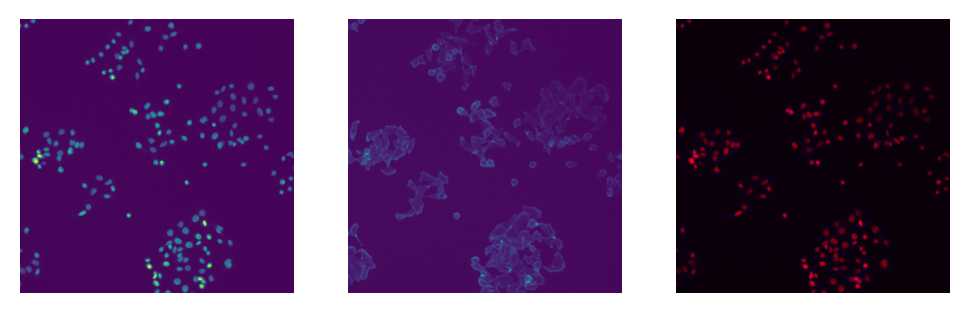

In [67]:
# Show combined data
fig, axs = plt.subplots(1, 3, dpi = 200)

axs[0].imshow(data1);
axs[0].axis('off');

axs[1].imshow(data3);
axs[1].axis('off');

axs[2].imshow(im); # Combined image
axs[2].axis('off')

plt.show()

and enlarged:

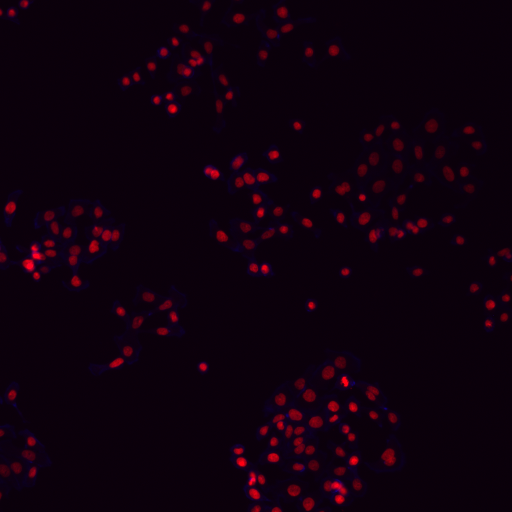

In [10]:
im

The combined image shows red (nuclei) and blue (cytoplasm) colors (look very carefully to see the darker shades of blue, present in the image).

## Data Exploration

In image analysis, one of the most common tasks is to look at the distribution of pixel intensities, and display this as a histogram. For example: we can count how many times each pixel value (or range) appears in an image, and display this as a bar. This allows us to get a quick estimate of the intensities present in an image and to check for problems like saturation. We are going to plot the intensities of channel 1 and 3 as histograms.  

We have already demonstrated that we can use Matplotlib’s `imshow` function to display an image. Now we look at a second plotting function from that library, which generates a histogram plt.hist(). We are aiming to compute the histogram on all pixels, and for this we cannot use our 2D image as an input. The image needs to first be flattened into a single series of numbers. This can be done with the ravel() method of the array:

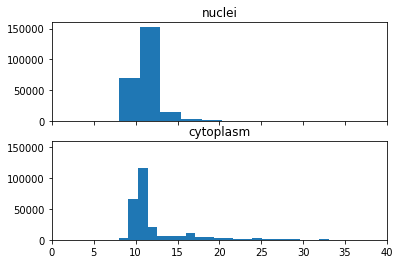

255 : 122


In [11]:
# Plot histogram
fig, axs = plt.subplots(2, sharex=True, sharey=True)

axs[0].hist(data1.ravel(), bins=100);
axs[0].set_title("nuclei");
axs[0].set_xlim(0,40)

axs[1].hist(data3.ravel(), bins=100);
axs[1].set_title("cytoplasm");
axs[1].set_xlim(0,40)

plt.show()

print(data1.max(), ":", data3.max())


The histograms show that there is a very high intensity of fluorescence for nuclei, relative to the cytoplasm, and this is the reason that red is more evident on the image, compared to blue. The intensities can be equalised by using a function *exposure.equalize_hist* from the **exposure** module in skimage library. This function returns an image which can then be used to plot a histogram.

/Users/sabaferdous/envL2D/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


(-0.5, 511.5, 511.5, -0.5)

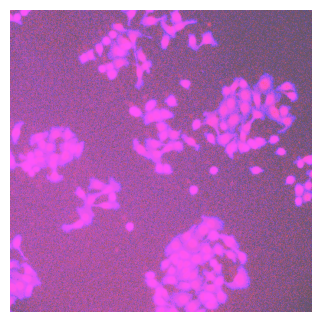

In [12]:
# Equalize histogram 
from skimage import exposure

img_eq = exposure.equalize_hist(data)

plt.figure(dpi=100)
plt.imshow(img_eq)
plt.axis('off')

In [71]:
# Exercise 1

# Plot a histogram for equalised image, and show intensities of nuclei and cytoplasm.

### OpenCV

To demonstrate the vast functionality available in Python, we will take a look at __OpenCV__. OpenCV (Open Source Computer Vision Library: http://opencv.org); an open-source library that includes several hundred computer vision algorithms.

For example, we can use functions to normalise our image data. Mathematical normalisation can be performed on images individually, or with respect to another channel. In the following example, we will normalise channel 3, with respect to channel 1. To do so, we calculate the mean and standard deviation of the pixel intensity of channel 1, and remove them from channel 3.


In [13]:
# Normalise to a different channel

import cv2 # GB - Explanation of package cv2
#print(cv2._version_)

# Calculate mean and STD
mean, STD = cv2.meanStdDev(data1)

# Clip frame to lower and upper STD
offset = 1
offset_nuclei = np.clip(im, mean - STD, mean + STD).astype(np.uint8)

# Normalise to range
result = cv2.normalize(offset_nuclei, np.uint8(data), 0, 255, norm_type=cv2.NORM_MINMAX)

(-0.5, 511.5, 511.5, -0.5)

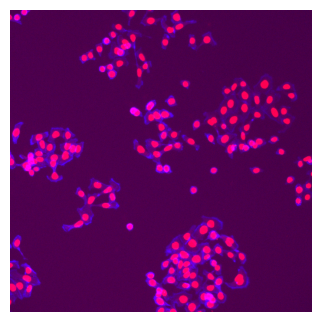

In [73]:
# Plot normalised image
plt.figure(dpi=100)
plt.imshow(result)
plt.axis('off')

In [ ]:
# Exercise 2

# Normalise the combined image with respect to cytoplasm?

# Tea Break

## Data Visualisation

Now we can plot histograms of the normalised intensities in channel 1, channel 3, and the background.

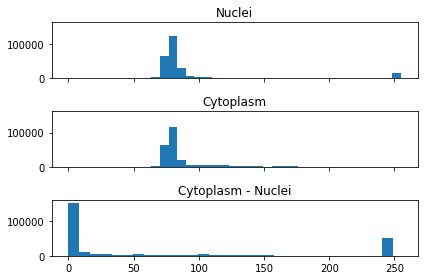

In [14]:
# Plot histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True)

axs[0].hist(result[:,:,0].ravel(), bins=30)
axs[0].set_title('Nuclei')

axs[1].hist(result[:,:,2].ravel(), bins=30)
axs[1].set_title('Cytoplasm')

axs[2].hist(result[:,:,2].ravel() - result[:,:,0].ravel(), bins=30)
axs[2].set_title('Cytoplasm - Nuclei')

fig.tight_layout()

plt.show()

The third histogram shows everything (background signal), except for nuclei and cytoplasm.

To investigate correlations between the intensities, we can look at a scatter plot (below left, once you run the cell, below). This type of plot is generally useful for exploratory data analysis. 

We can see that the scatter plot is quite dense, and it is not really possible to see how many points are present, at a given location. We can display this information with the two-dimensional histogram (below centre). This clearly shows the count of points that fall into a certain square of intensities. (Note the thin, yellow area towards the right margin).

### Seaborn
From a python plotting library called [seaborn](https://seaborn.pydata.org), we can import a function called `kdeplot`, which allows us to make a contour plot of the intensities. The contour plot confirms that there are at least two distinct distributions. Such a finding might inspire grouping the intensities into different categories, or clusters.

> Note that this plot might take a bit longer to run, as there are a large number of data points. 


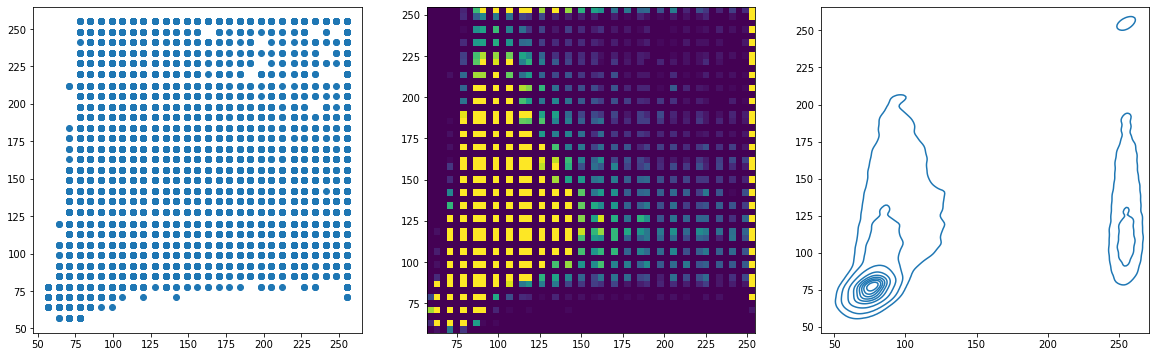

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Scatter plot
ax[0].scatter(result[:,:,0].flatten(), result[:,:,2].flatten())

# # 2D Histogram
ax[1].hist2d(result[:,:,0].flatten(), result[:,:,2].flatten(), bins=50, vmax=50);

from seaborn import kdeplot

 # Density Plot
kdeplot(x=result[:,:,0].flatten(), y=result[:,:,2].flatten(), ax=ax[2]);


## Selecting part of an image

It is also possible to analyse a small region of an image. The image can be cropped, and then analyses can be performed on the selected region.

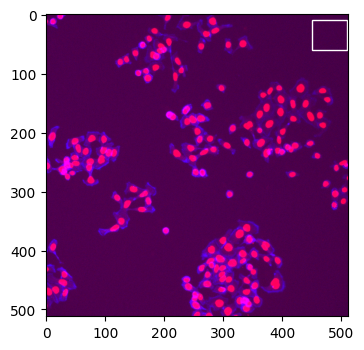

In [76]:
# Annotating the regions
from matplotlib.patches import Rectangle

x, y, w, h = 450, 10, 60, 50

fig, ax = plt.subplots(dpi = 100)

plt.imshow(result)

ax.add_patch(Rectangle((x,y), w, h, edgecolor="w", fill=False));


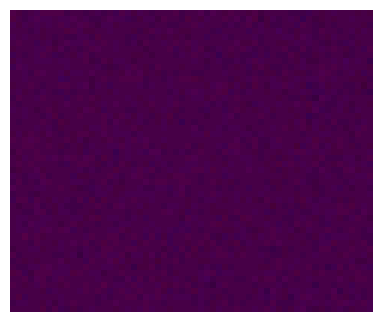

In [77]:
# plot what's in box
fig, ax = plt.subplots(dpi=100)
plt.imshow(result[y:y+h, x:x+w,])
plt.axis('off')
plt.show()

In [78]:
result[y:y+h, x:x+w, 0].shape
result[:,:,0].shape

(512, 512)

The region in the rectangle does not have any cells. Plotting a histogram for this region versus full image will result in the following plot. 

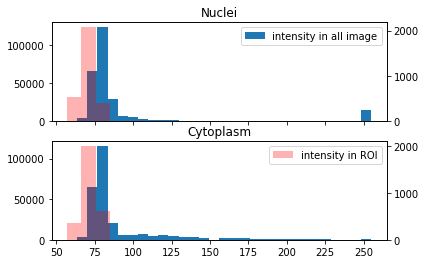

In [79]:
# Plot histogram 
fig, axs = plt.subplots(2, sharex=True)

axs[0].hist(result[:,:,0].ravel(), bins=30, label='intensity in all image');
axs0_2 = axs[0].twinx()
axs0_2.hist(result[y:y+h,x:x+w,0].ravel(), bins=3, color='r', alpha=0.3)
axs[0].set_title('Nuclei')
axs[0].legend()

axs[1].hist(result[:,:,2].ravel(), bins=30)
axs1_2 = axs[1].twinx()
axs1_2.hist(result[y:y+h,x:x+w,2].ravel(), bins=3, color='r', alpha=0.3, label='intensity in ROI')
axs[1].set_title('Cytoplasm')

plt.legend()
plt.show()

This plot compares the intensity of the pixels in the total image (blue) to those in the region of interest (ROI) bounded by the rectangle. If we move the ROI over cells, we can see how this intensity changes. 

In [ ]:
# Exercise 3

# Move the rectangle towards left so that it have a few cells. Now plot the histogram again and see the differences.

In [ ]:
# Exercise 4

# Repeat this process for other images (in the folder) and save 3-4 examples of cells with nuclei and cytoplasm marked


# Lunch Break

## Image clustering

[Clustering Methods](https://scikit-learn.org/stable/modules/clustering.html)


![Methods Comparison](ClusterMethods.png)
![Success Comparison](Clustering_comparison.png)



In [80]:
# Preparing the data for clustering

img1 = result[:,:,0].reshape(-1, 1)
img2 = result[:,:,2].reshape(-1, 1)

all_imgs = np.concatenate([img1, img2], axis=1)

all_imgs.shape

(262144, 2)

In [81]:
# Import the clustering class
from sklearn.mixture import GaussianMixture

In [87]:
# Cluster the images and obtain the labels for each pixel
n_components = 3

RANDOM_STATE = 12345

gmm = GaussianMixture(n_components=n_components, 
                      random_state=RANDOM_STATE)

all_img_labels = gmm.fit_predict(all_imgs)

all_img_labels[0]


0

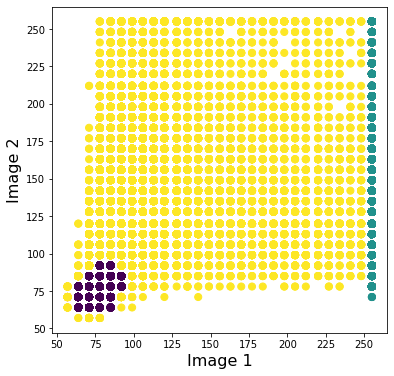

In [83]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(img1[img1 > 0], img2[img2 > 0], c=all_img_labels, s=50)

ax.set_xlabel('Image 1', fontsize=16)
ax.set_ylabel('Image 2', fontsize=16);


In [84]:
from numpy import zeros

mask = (data1>0) & (data3>0) 

all_img_labels_mapped = zeros(data1.shape)

all_img_labels_mapped[mask] = all_img_labels

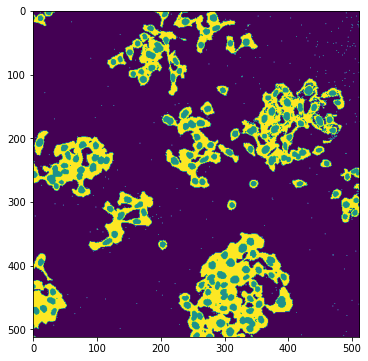

In [85]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(all_img_labels_mapped);

The result depends critically on the specified number of clusters.

In [ ]:
# Exercise 5: Change n_components to 2, 4, 5 and 6 and compare the results.

In [86]:
# Exercise 6: Apply the Kmeans algorithm to the images and compare the result of the 
# clustering for different choices of n_components.
#
# Documentation: 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#
# To import:

from sklearn.cluster import KMeans

# Tea Break

## Segmentation

Image segmentation allows us to locate objects and boundaries (lines, curves, *etc.*) within an image. Conventional methods make use of a threshold value to distinguish between different regions and/or cells. In this lesson, we will use a Python package called [**StarDist**](https://github.com/stardist/stardist), which makes use of deep learning methods to perform nuclei segmentation. It is designed particularly for nuclei segmentation. **StarDist** comes with pretrained models, that are likely suitable for your micrograph images. However, it is also possible to train your model specifically for your dataset. 


(-0.5, 511.5, 511.5, -0.5)

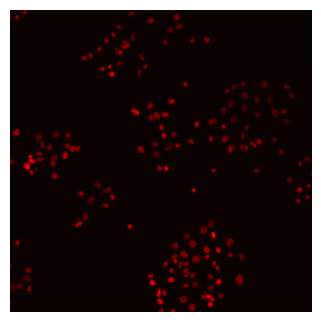

In [88]:
## Load as images - Using Raw images

data1 = Image.open(ch1_files[0])

nuclei = np.zeros(np.shape(im))
nuclei[:, :, 0] = data1

plt.figure(dpi=100)
plt.imshow(nuclei.astype(int))
plt.axis('off')

In [89]:
from stardist.models import StarDist2D
from stardist import random_label_cmap

from csbdeep.utils import Path, normalize

axis_norm = (0,1)   # normalize channels independently
img = normalize(nuclei[:,:,0], 1,99.8, axis=axis_norm)

model = StarDist2D.from_pretrained('2D_versatile_fluo')
lbl_cmap = random_label_cmap()

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In order to access pretrained models, the function *StarDist2D.from_pretrained()* provides a list from which a suitable model can be selected. There are two main types of models: one for fluorescent images, and the other for brightfield images. For our image, **StarDist** will perform nuclei prediction using *2D_versatile_fluo*.

In [90]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [91]:
# Using pre-trained network to predict nuclei
labels, details = model.predict_instances(img)

1/1 [==============================] - 0s 221ms/step


2022-09-15 15:40:26.344771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


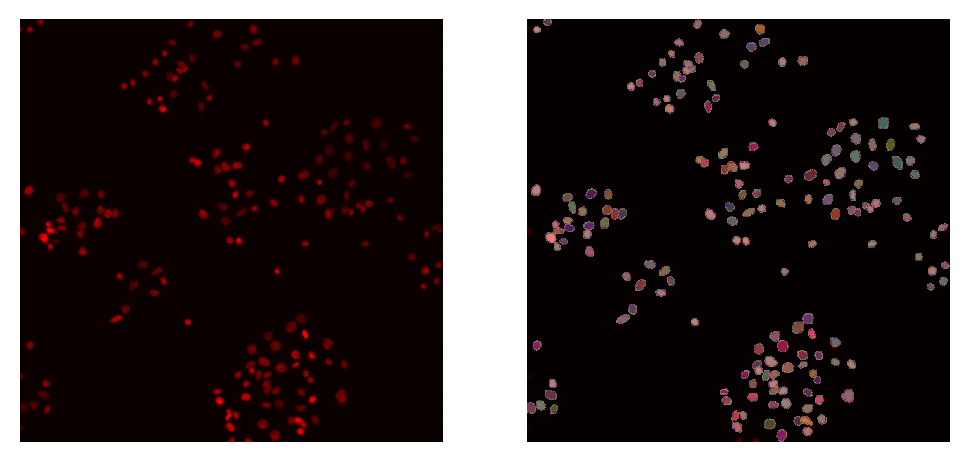

In [92]:
## Show data

fig, axs  = plt.subplots(1,2, dpi=200)
axs[0].imshow(nuclei.astype(int))
axs[0].axis('off')

axs[1].imshow(nuclei.astype(int))
axs[1].imshow(labels, cmap=lbl_cmap,alpha=0.5)
axs[1].axis('off')
plt.show()

The image on the right is a segmented image, with correctly identified and predicted nuclei. This image is also referred to as a masked image. The next step will allow us to count the number of nuclei in this image, which is performed as follows:

The total number of nuclei in the image are:  168


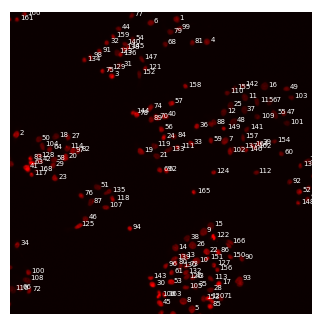

In [93]:
# Enumerate nuclei
plt.figure(dpi=100)
plt.imshow(nuclei.astype(int))

for i, xy in enumerate(details['points']):
    plt.annotate(str(i+1), [xy[1]+5,xy[0]], color='w', size=5)
plt.axis('off')

print("The total number of nuclei in the image are: ", len(details['points']))

In [94]:
# Exercise 7
# Repeat segmentation for other images.

In [95]:
# Exercise 8
# Repeat segmentation for all 12 images and plot number of nuclei per image.

In [96]:
# Exercise 9
# Repeat segmentation for cytoplasm channel, what do you notice? Explain your observation for any pecularities.

If you have done the above exercise of using **stardist** to perform segmentation for the cytoplasm channel, then you may have noticed pecularities. These can be justified by StarDist really only being designed for accurate segmentation of nuclei. However, if you are interested in cytoplasm segmentation, then using **cellpose** is better suited for this application. This Python package is more specialised, and better apllied to cell and nucleus segmentation. After completing this workshop, you will observe that **stardist** and **cellpose** both work in a similar fashion. For more information and documentation, please follow this [link](https://github.com/MouseLand/cellpose).

## Summary and Conclusions

In undertaking this workshop, we have learned to import, explore and analyse fluorescence microscopy images, and how to perform some basic image analyses using several packages, in Python. We have also learned how to perform clustering analyses, through implementing unsupervised machine learning algorithms (GMM). Further to this, we provided an introduction into the use of deep learning algorithms for use in nuclei segmentation, which can provide a fast, accurate and powerful count of the nuclei present in an image; this can be invaluable for analysing large amounts of data. Following the guided links, you can start to explore more advanced image analysis techniques, and *Learn To Discover* how these can help you further your own work, and reserach.
